## Dataset analysis

Let's combine what we've learned so far in a detailed analysis of the gene expression dataset.
Dataset 4 provides the gene expression profiles of patients from Venus and Earth across a set of 300 genes. This exercise includes producing a range of plots for demonstration purposes which are not graded.

In [53]:
library(tidyverse, quietly = TRUE)
library(corrr, quietly = TRUE)
library(testthat, quietly = TRUE)
# library(factoextra, quietly = TRUE)

In [54]:
# Load dataset 4
ds4 <- read.csv("./data/DATA_SET_REFERENCE_4_A.csv", row.names = 1)
ds4 <- ds4[complete.cases(ds4),]

# log-transform 
ds4.lg <- log1p(ds4)
# and have a look
head(ds4.lg)
dim(ds4.lg)

,Venus,Venus.1,Venus.2,Venus.3,Venus.4,Venus.5,Venus.6,Venus.7,Venus.8,Venus.9,⋯,Earth.6,Earth.7,Earth.8,Earth.9,Earth.10,Earth.11,Earth.12,Earth.13,Earth.14,Earth.15
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gene1,9.116664,8.561232,7.295293,7.819285,7.535472,7.424598,8.236655,8.520428,6.785104,7.383238,⋯,13.479240,12.574869,13.481223,15.107209,12.265680,9.728407,13.319374,10.444880,13.598183,12.551108
Gene2,10.489192,10.480852,11.831907,11.902300,12.370216,10.489389,12.041634,11.831059,10.734687,11.895654,⋯,10.508774,11.871755,9.650766,9.616328,11.668164,10.472336,11.680495,7.780469,13.112663,10.890570
Gene3,2.051594,2.962843,3.081236,1.520464,2.382751,2.389704,1.858336,1.385075,2.001432,1.087740,⋯,5.471515,6.375352,6.080026,6.985495,4.821338,6.249075,6.751317,6.460559,5.097344,6.254165
Gene4,7.159051,6.240134,8.013059,7.224445,6.370180,7.399422,6.835413,7.016504,6.794937,7.121494,⋯,6.793537,6.462440,6.458874,7.070621,5.960645,8.123408,5.376140,5.557736,8.042529,6.921164
Gene5,4.255661,5.234989,4.996952,5.355063,4.801502,4.078354,4.592350,4.432914,4.771621,4.520638,⋯,5.338306,5.523175,3.481163,5.413985,4.688170,5.689060,4.976054,5.266078,5.269465,4.233020
Gene6,8.277948,10.770854,11.598517,11.324582,11.236849,10.064917,10.736934,9.550320,9.289750,10.396599,⋯,8.826663,9.769692,10.903169,11.764852,10.267039,10.022308,11.018959,11.409184,10.133269,10.084636


[1] 300  32


## PCA

First of all, we should check how the total variation in the dataset between patients is distributed. A principal component analysis is a quick and easy way to do this.

In [55]:
ds4.lg.pca <- prcomp(t(ds4.lg), scale. = FALSE, center = FALSE)
s <- summary(ds4.lg.pca)


In [56]:
### BEGIN HIDDEN TEST
test_that("Make sure to assign the summary of the PCA object to the variable s.", {
    expect_equal(class(s), "summary.prcomp")
})

test_that("Make sure to perform the PCA on the patients, not the genes.", {
    expect_equal(nrow(ds4.lg.pca$x), ncol(ds4.lg))
})

test_that("Something went wrong in the PCA or summary step.", {
    expect_equal(s, summary(ds4.lg.pca))
})
### END HIDDEN TEST

Test passed 🎊
Test passed 🥳
Test passed 🥇


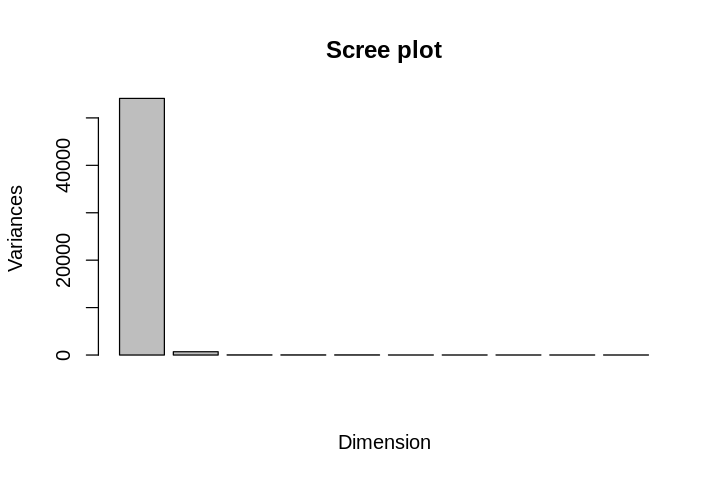

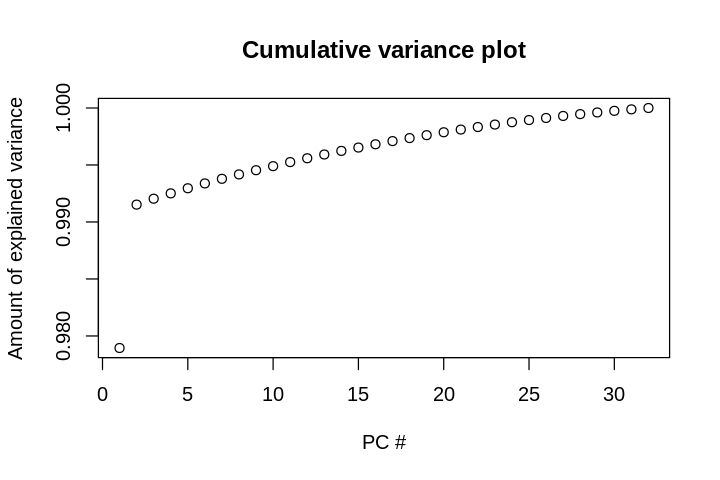

In [57]:
# Lets examine the PCA result closer. The scree plot shows us which dimensions 
# carry the majority of the variation.
options(repr.plot.width = 6, repr.plot.height = 4)
plot(ds4.lg.pca,
	xlab = "Dimension",
	main = 'Scree plot')

# cumulative explained variability plot
cp <- cumsum(ds4.lg.pca$sdev^2 / sum(ds4.lg.pca$sdev^2))
plot(cp, 
    xlab = "PC #", 
     ylab = "Amount of explained variance", 
     main = "Cumulative variance plot"
    )
# The vast majority of variance in the dataset (98%) is represented in the first principal component!
col.by.planet <- rep('Earth', ncol(ds4.lg)) 
col.by.planet[grep('Venus', colnames(ds4.lg))] <- 'Venus'

# now lets look at whether the patients cluster somehow
# library(factoextra)
# options(repr.plot.width = 6, repr.plot.height = 6)

# fviz_pca_ind(ds4.lg.pca,
#              axes = c(1, 2),
#              geom = c("point"),
#             col.ind = col.by.planet)


We can run some t-test now to find genes which are causing this expression difference between the planets.

In [58]:
# your code here
venus.idx <- grep('Venus', colnames(ds4.lg))
earth.idx <- grep('Earth', colnames(ds4.lg))
gene1.venus.vs.earth <- t.test(unlist(ds4.lg['Gene1', venus.idx]), unlist(ds4.lg['Gene1', earth.idx]))


In [59]:
### BEGIN HIDDEN TEST
test_that("Make sure to select only Venus patients in venus.idx.", {
    expect_equal(venus.idx, grep('Venus', colnames(ds4.lg)))
})

test_that("Make sure to select only Earth patients in venus.idx.", {
    expect_equal(earth.idx, grep('Earth', colnames(ds4.lg)))
})

test_that("Make sure to store the t-test as gene1.venus.vs.earth.", {
    expect_equal(class(gene1.venus.vs.earth), "htest")
})

test_that("Make sure to calculate the two-sided t-test.", {
    expect_equal(gene1.venus.vs.earth$p.value, 
                 t.test(
                     ds4.lg['Gene1',grep('Venus', colnames(ds4.lg))], 
                     ds4.lg['Gene1',grep('Earth', colnames(ds4.lg))]
                 )$p.value)
})
### END HIDDEN TEST

Test passed 🌈
Test passed 🎉
Test passed 🎊
Test passed 😸


In [60]:
# It is not practical to do this for each gene, so let's write a loop to perform a two-sided t-test for every 
# gene and store the resulting p-value in a vector "p.vals". 
# Alternatively, you can use apply to achieve the same.

p.vals <- apply(ds4.lg, 1, function(gene_expression_row) {
    # Assuming earth.idx and venus.idx are defined elsewhere and correctly subset the columns
    t_test_result <- t.test(gene_expression_row[earth.idx], gene_expression_row[venus.idx])
    return(t_test_result$p.value)
})


In [61]:
### BEGIN HIDDEN TEST

pv <- apply(ds4.lg, 1, 
                 function(x) 
                     t.test(x[earth.idx],x[venus.idx])$p.value
                 )

test_that("Make sure to store all p-values in the vector.", {
    expect_equal(length(p.vals), nrow(ds4.lg))
})

test_that("Make sure to store all p-values in the vector.", {
    expect_equal(length(p.vals), nrow(ds4.lg))
})

# can store p-vals as list or vector. want to be independent from that and only care about the p-values, 
# i.e. the sum of equality tests
test_that("Make sure to calculate a two-sided t-test and store only the p-value.", {
    expect_equal(sum(pv == p.vals), nrow(ds4.lg))
})
### END HIDDEN TEST

Test passed 😸
Test passed 🎉
Test passed 🥇


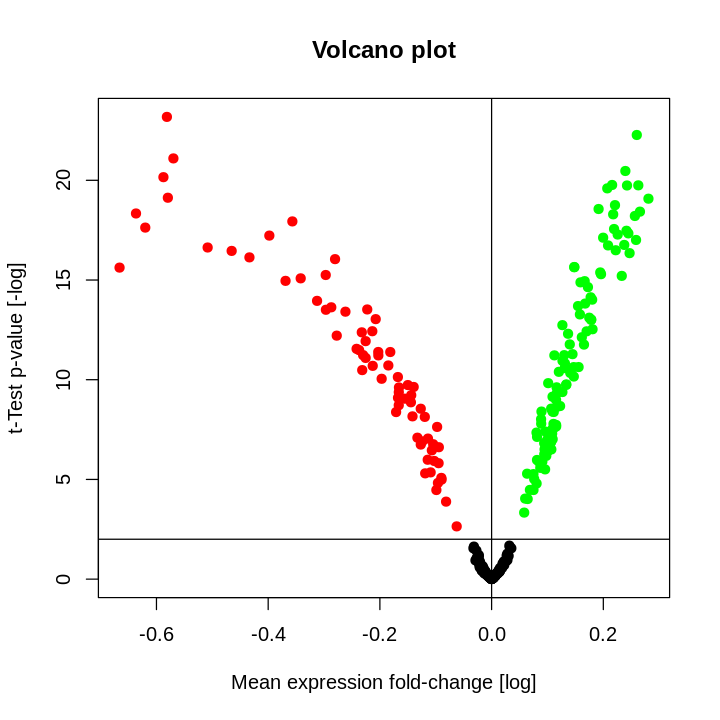

In [62]:
# A volcano plot visualizes the observed magnitude of gene expression change relative to the 
# statistical significance of that change assigned to the employed statistical method.

fc.log <- log10(apply(ds4.lg[,venus.idx], 1, mean) / apply(ds4.lg[,earth.idx], 1, mean))
col.fc <- rep('black', nrow(ds4.lg))
col.fc[p.vals < 0.01 & fc.log < 0] <- 'red'
col.fc[p.vals < 0.01 & fc.log > 0] <- 'green'

options(repr.plot.width = 6, repr.plot.height = 6)
plot(fc.log, -log10(unlist(p.vals)), 
     main = 'Volcano plot',
     xlab = 'Mean expression fold-change [log]',
     ylab = 't-Test p-value [-log]',
    col = col.fc,
    pch = 19)
abline(h = -log10(0.01), v = 0)

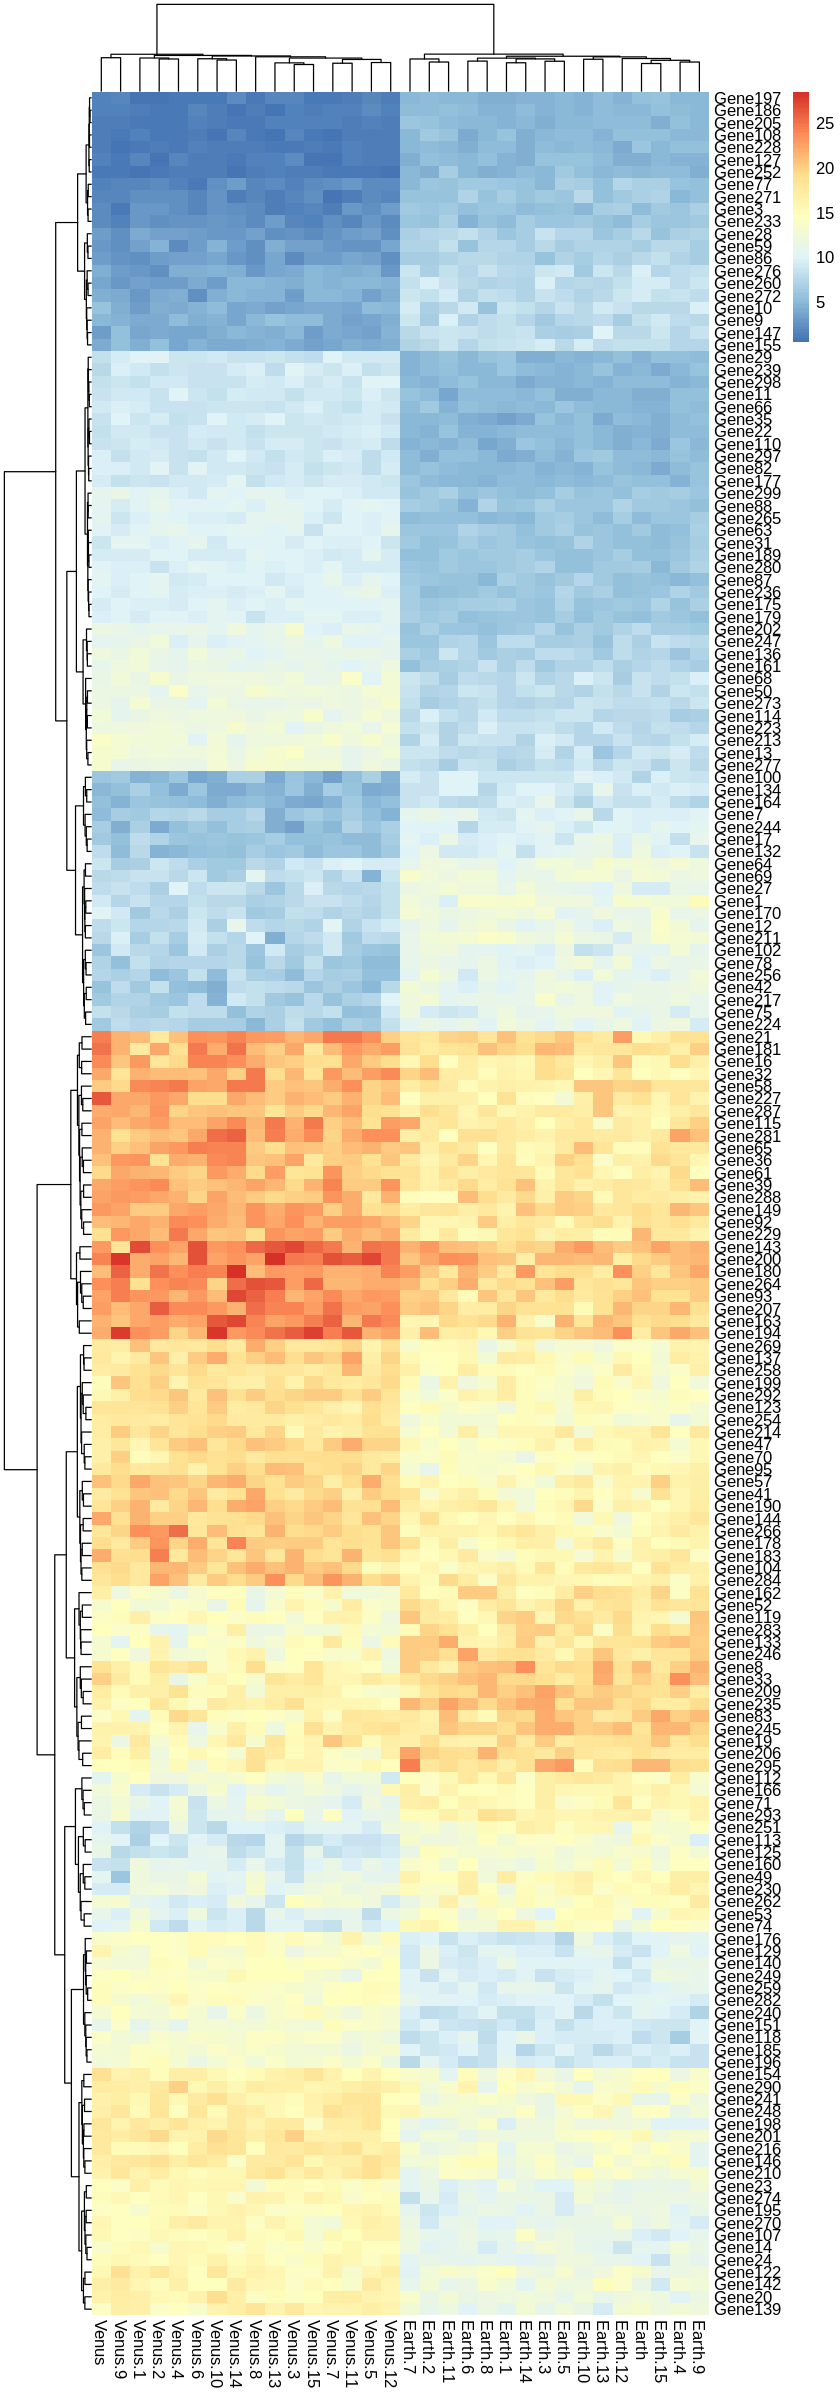

In [63]:
# A visual representation of the differentially expressed genes is very helpful. 
# Usually a heatmap is used for that purpose.
library(pheatmap)

# Create a logical vector "de.idx" indicating genes with significant p-values from the t-test, using a 
# p-value cutoff of 0.01. We can use the vector "p.vals" from earlier.
# de.idx <- 
# your code here
de.idx <- p.vals < 0.01

# A volcano plot visualizes the observed magnitude of gene expression change...
fc.log <- log10(apply(ds4.lg[,venus.idx], 1, mean) / apply(ds4.lg[,earth.idx], 1, mean))


options(repr.plot.width = 7, repr.plot.height = 20)
pheatmap(ds4.lg[de.idx,], cluster.cols = FALSE)

In [64]:
### BEGIN HIDDEN TEST

idx <- p.vals < 0.01

test_that("The index has to include all genes.", {
    expect_equal(length(de.idx), nrow(ds4.lg))
})

test_that("Make sure to calculate a two-sided t-test and store only the p-value.", {
    expect_equal(idx, de.idx)
})
### END HIDDEN TEST

Test passed 🌈
Test passed 😀


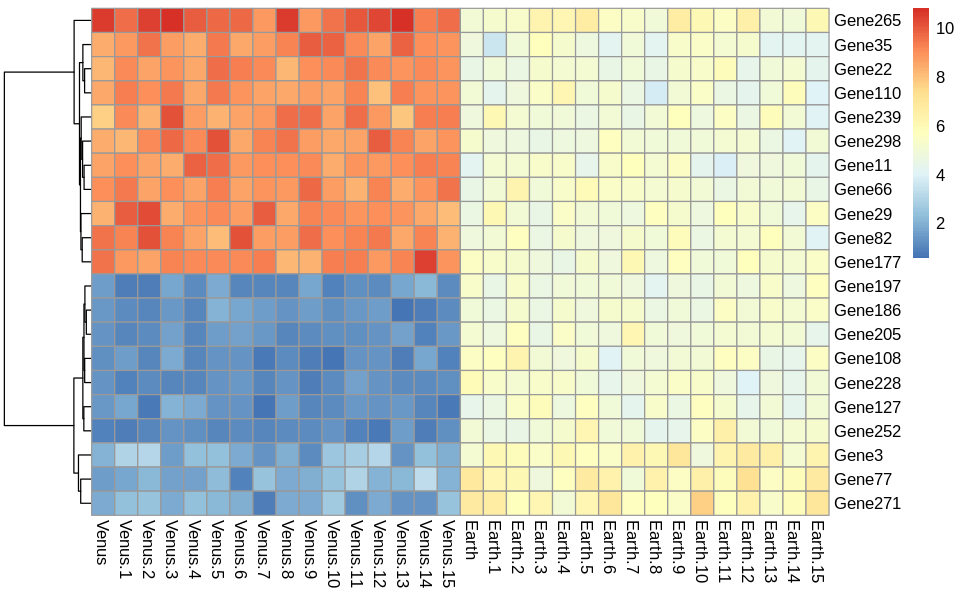

In [65]:
# And lastly, lets concentrate on the ten genes with the largest expression increase and decrease between planets.
# Firstly, we need to find the thresholds for the genes with highest and lowest fold-change.
neg.thr <- sort(fc.log)[10]
pos.thr <- sort(fc.log)[length(fc.log)-10]

# We then apply the thresholds to create a logical index for our genes of interest.
idx <- which(fc.log >= pos.thr | fc.log <= neg.thr)

# And lastly visualize them as heatmap.
options(repr.plot.width = 8, repr.plot.height = 5)
pheatmap(ds4.lg[idx,], cluster_cols = FALSE)